# Lattice QCD
Last revised: 4-22-2022 by Richard Mueller [rjm6826@psu.edu]

An introduction to lattice QCD based on 'Lattice QCD for Novices' by Peter Lepage.

Revisions:
* v2: Tests if removing the Nth integral improves results.

TODO:
* Path integrals 
    * paths must end/start at the same points
    * Approximating p_{j+1} as p_j
* Discretized path integrals
    * fix e^-HT in the propogators
* All integral methods through monte carlo -- record the time it takes to perform each
* Applications #2 section doesn't make any sense
* Need to plot comparisons with HO states and energies. Take sqrt of all integration outputs
* what is the diamter of a typical hadron?

$$\newcommand{\bra}[1]{\langle{#1}|}$$
$$\newcommand{\ket}[1]{|{#1}\rangle}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\bramket}[3]{\left\langle{#1}|{#2}|{#3}\right\rangle}$$

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import time

## The Path Integral

Let's look at the Schodinger equation in the time independent case. Time evolution is governed by

$$ i\hbar\partial_{t}\ket{\psi(t)} = H\ket{\psi(t)} \Longrightarrow \ket{\psi(t)} = U(t,t')\ket{\psi(t)} $$
$$ U(t,t') = e^{-iH(t-t')/\hbar} $$

provided that $ t > t' $. $ U(t,t') $ is called the time evolution operator: acting on a position $ \ket{x} $ with it will tell us where a wave at position x at time t will wind up at time t'. The matrix element 

$$ \bramket{x}{U(t,t')}{x'} = \bramket{x}{e^{-iH(t-t')/\hbar}}{x'} \equiv U(x,t;x',t') $$

then tells us the expected value of the propogated wave at x',t'. This function lends $ U(x,t;x',t') $ its name of *propogator*. **Complete knowledge of the propogator, given an initial state, provides complete information about the wave dynamics** (or field dynamics soon... hopefully):

$$
\begin{align}
    \psi(x,t) = \bramket{x}{U(t,t')}{\psi(t')} &= \int dx' \bramket{x}{U(t,t')}{x'} \braket{x'}{\psi(t')} \\
                                               &= \int dx' \bramket{x}{U(t,t')}{x'} \psi(x',t') \\
                                               &= \int dx' U(x,t;x',t') \psi(x',t')
\end{align}
$$

It can be shown that the propogator may be partitioned into $n$ time steps $ \delta t $ such that [?]

$$
U(x,t;x',t') = \int \prod_{j=1}^{n} \frac{dp_j}{2\pi\hbar} \prod_{j=1}^{n-1} dx_j e^{-i\delta{t}/\hbar \sum_{j=0}^{n-1}\left[T(p_{j+1}) + V(x_j) - \frac{p_{j+1} (x_{j+1} - x_j)}{\delta{t}} \right] }
$$

The $ \frac{(x_{j+1} - x_j)}{\delta{t}} $ can be identified as the discritized time derivative of $x_{j}$, $\dot{x_{j}}$. Hence the exponent can be identified with the discretized action,

$$ \begin{align}
S = -\delta{t} \sum_{j=0}^{n-1} \left[T(p_{j+1}) + V(x_j) - \frac{p_{j+1} (x_{j+1} - x_j)}{\delta{t}} \right] &= -\delta{t} \sum_{j=0}^{n-1}\left[T(p(t_j)) + V(x(t_j)) - p(t_j)\dot{x}(t_j)\right] \\
                                                                                     &= \delta{t} \sum_{j=0}^{n-1}L(x_j,p_j,t') 
\end{align}
$$

In the continuum limit ($ \delta{t} \rightarrow 0 $ ) we are able to eliminate the integral of $p$ (gaussian):

$$
U(x,t;x',t') = \int D[x] \ e^{i/\hbar S[x]} = \int D[x] \ exp\left[i/\hbar \sum_{j=0}^{n-1}L(x_j,\dot{x}_j,t') \right]
$$

where $ D[x] = \prod_{j=1}^{n-1} dx_j $. Our goal now is to find an efficient way to compute this quantity.

## The Discritized Path Integral


### Representing an arbitrary particle path
A general path $ x(t) $ from $x_i$ to $x_f$ can be arbitrarily long an complex. However, the contribution to the propogator from these paths are actually supressed! We can see this by exploring the action in the *finite difference approximation*.

When given a path (or, in general, any function) $x(t)$, we can break it into discretized time steps... Maybe just use the explanation from the path integral derivation?

We approximate the path by specifying $x(t)$ only at the nodes, or sites, of a discretized time line:

$$ t_n = t_i + a*n $$

for $n=0,1,2,...,N$ and where $a$ is the *grid spacing*. The path is represented as a vector of numbers,

$$ x = \left[ x(t_0),x(t_1),...,x(t_N)\right] $$

So, the integral over all paths becomes the integral over all possible values of $x$ at each node:

$$ \int D[x(t)] \longrightarrow A\int_{-\infty}^{\infty} dx_1 dx_2 ... dx_{N-1} $$

Note, the endpoint nodes $x_0,x_N$ are not integrated over, since they are held fixed/defined for all paths. $A$ is the integration normalization factor, which will be useful in the examples which follow. In one dimension, it is $ A = \left( \frac{m}{2\pi a} \right)^{N/2} $ [?].

#### Evaluation of the action: The finite difference approximation
With these tools, our focus becomes

$$ \bramket{x}{e^{-HT}}{x} \approx A\int_{-\infty}^{\infty} dx_1 dx_2 ... dx_{N-1} e^{-S_{lat}[x]} $$

where $ S_{lat}[x] $ is given by

$$ S_{lat}[x] = \sum_{j=1}^{N-1} \left(T(x_j) + V(x_j) \right) = \sum_{j=0}^{N-1} \left( \frac{m}{2a}\left(x_{j+1} - x_j \right)^2 + aV(x_j) \right) $$

Note, when the difference between successive time steps is large, the exponential factor contributes less. Hence, paths which vary quickly are supressed in the integration.

### Application #1: Finding the ground state of a positive valued wavefunction
We first turn our interest to those propogators who time evolve for long periods of time $ T = t - t' $: the self propogator is
$$ \bramket{x}{e^{-HT}}{x} = \sum_{n} \braket{x}{E_n}e^{-E_n T}\braket{E_n}{x} $$

If T is large enough, only the lowest energy term will significantly contribute:
$$ \bramket{x}{e^{-HT}}{x} \longrightarrow^{T\to\infty} e^{-E_0 T} \left|\braket{x}{E_0}\right|^2 $$

Integrating over x provides the ground state energy,
$$ \int dx \bramket{x}{e^{-HT}}{x}  \longrightarrow e^{-E_0 T} $$

The ground state wavefunction is then determined 
$$ \ket{E_0 (x)} = \braket{x}{E_0} = \left[e^{E_0 T} \bramket{x}{e^{-HT}}{x} \right]^\frac{1}{2} $$

Once we fix T,n, we can calculate
* $E_0$ from $ \int dx \bramket{x}{e^{-HT}}{x} $
* $ \ket{E_0 (x)} $ from $ \bramket{x}{e^{-HT}}{x} $

### An example: Ground state of the harmonic oscillator

Lets keep track of our oscillator properties

In [2]:
# Let's keep track of our wavefunction properties
hbar = 1
class oscillator():
    def __init__(self, boundaries, N=8, m=1, k=1, **kwargs):
        self.bdd = boundaries # extent of the wavefunction
        self.N = N # N: time steps
        self.m = m # a: oscillator mass
        self.k = k # k: oscillator strength

        # Grid spacing
        if "a" in kwargs: self.a = kwargs["a"]
        else: self.a = .5

        self.A = (self.m/(2*np.pi*self.a))**(self.N/2) # Wave function normalization
        
    # Return the HO potential
    def harmonicV(self,x):
        return .5*self.k*x**2

We'll want to compare our results to the exact solution. Below are some tools for that.

In [3]:
class ExactHarmonicOsc(oscillator):
    def __init__(self, boundaries, N=8, m=1, k=1, **kwargs):
        super().__init__(boundaries, N=8, m=1, k=1, **kwargs)
        self.w = np.sqrt(self.k/self.m)

    # Return the HO ground state
    def HO_GS(self,x):
        amp = ((self.m*self.w)/(np.pi*hbar))**(1/4)
        return amp*np.exp(-self.m*w*self.x**2 / (2*hbar))

    # Return the HO first excited state
    def HO_E1(self,x):
        amp = ((self.m*self.w)/(np.pi*hbar))**(1/4) * np.sqrt(2*m*w/hbar)*x
        return amp*np.exp(-(self.m*self.w)*x**2 / (2*hbar))

    # Return the HO energy of the nth state
    def HO_E(self,n):
        return (n+1/2)*hbar*self.w

Here are the tools needed for computing the path integral for the harmonic oscillator.

In [4]:
l = [1,2,3,4]
l.insert(len(l),5)
print(l)
print(l[:-1])
print(range(len(l)-1))
print(l[-1])

[1, 2, 3, 4, 5]
[1, 2, 3, 4]
range(0, 4)
5


In [16]:
class DiscHarmonicOsc(oscillator):
    def __init__(self, boundaries, N=8, m=1, k=1, **kwargs):
        super().__init__(boundaries, N=8, m=1, k=1, **kwargs)
    
    # Return the action
    def S(self,x,xi):
        KE = self.m/(2*self.a) * (x[0] - xi)**2
        PE = self.a * self.harmonicV(xi)
                
        for i in range(len(x)-1):
            KE += self.m/(2*self.a) * (x[i+1] - x[i])**2
            PE += self.a * self.harmonicV(x[i])
            
        KE += self.m/(2*self.a) * (xi - x[-1])**2
        PE += self.a * self.harmonicV(x[-1])
        
        # print(xi, KE+PE)
            
        return (KE+PE)
    
    # Returns e^(-S[x])
    def expS(self,*args):
        x = list(args)[:-1]
        xi = args[-1]
    
        return self.A*np.exp(-self.S(x, xi))
    
    # def makeGS(self,x):
        


We can integrate over the N-2 variables numerically using 'scipy's numerical integration package for vectors.

In [20]:
d_osc1 = DiscHarmonicOsc(boundaries=[-4, 4], N=4, m=1, k=1)

xmax = 2.4
nxpts = 12
xGrid = np.linspace(0, xmax, nxpts)
quadResult = np.zeros_like(xGrid)

start = time.time()
for i,xi in enumerate(xGrid):
    quadResult[i] = integrate.nquad(func = d_osc1.expS, ranges = (d_osc1.N-2)*[d_osc1.bdd], args = (xi,), opts={'points': [-2,2]}) #,
                                                                                                                # 'epsabs': 1e-3, 'epsrel': 1e-1})[0]
    print(quadResult[i])
    
end = time.time()
print("Time elapsed: {} s".format(end-start))

KeyboardInterrupt: 

In [ ]:
def expS_lat(*x):
    x0 = x[-2]
    N = int(x[-1])
    
    xx = list(x)[:(N-1)]
    xx.insert(0,x0)
    xx.insert(N,x0)
    
    KE, PE = 0.,0.
    
    for i in range(len(xx)-1):
        KE += m/(2*a) * (xx[i+1] - xx[i])**2
        PE += a * harmonicV(xx[i])
        
    return A*np.exp(-(KE+PE))

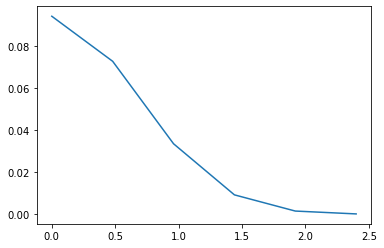

In [112]:
plt.plot(xGrid,quadResult)

## Monte Carlo Evaluation of Path Integrals

### The Monte Carlo evaluation method

Our goal is to compute

$$ \int_{\vec{x}\in D} f(\vec{x})d\vec{x} $$

Doing some quick rearranging,

$$ \int_{\vec{x}\in D} f(\vec{x})d\vec{x} = \int_{\vec{x}\in D} \frac{f(\vec{x})}{p(\vec{x})} p(\vec{x}) d\vec{x} 
    \equiv \int_{\vec{x}\in D} g(\vec{x}) p(\vec{x}) d\vec{x} = E\left[g(\vec{x})\right] $$
    
In the discretized case, this is equivalent to

$$ E\left[g(\vec{x})\right] = \sum^N_{j=0} \frac{1}{N} g(\vec{x}_j) = \sum^N_{j=0} \frac{1}{N} \frac{f(\vec{x}_j)}{p(\vec{x}_j)} $$

We previously identified $ p(\vec{x}) $ as a probability distribution: if we take it to be uniform, and that all variables have the same domain of integration, then all $\vec{x}_j$ have the same probability of occuring within the sample:

$$ \int^{\vec{x}_f}_{\vec{x}_i} f(\vec{x})d\vec{x} \approx \sum^N_{j=0} \frac{1}{N} \frac{f(\vec{x}_j)}{\frac{1}{|\vec{x}_f - \vec{x}_i|}} = \sum^N_{j=0} \frac{|\vec{x}_f - \vec{x}_i|}{N} f(\vec{x}_j) $$

if $ b > a $, for finite $ N $.


### Revisited: The harmonic oscillator ground state

Recall, in our evaluation of the harmonic oscillator ground state, we were effectively taking the integral of $ e^{-S[x]} $: so, set $ f(\vec{x}) \equiv e^{-S[x]} $. We can still use the uniform distribution--there is a weight $ e^{-S[x]} $ assigned to each path, so the weights themselves are uniformly distributed across the domain.

We now calculate

$$ \sum^N_{j=0} \frac{|\vec{x}_f - \vec{x}_i|}{N} e^{-S[x]} $$

In [4]:
N = 8 # time steps
ti,tf = 0,N/2 # Initial time and Final time stamps
a = (tf - ti)/ N # Grid spacing
m = 1 # particle mass
k = 1 # oscillator strength
A = (m/(2*np.pi*a))**(N/2) # Wave function normalization

xBounds = [-4, 4] # bounds of integration
xmax = 2.4
xGrid = np.linspace(0,xmax,N) # Grid of xpts for our wf
vTest = harmonicV(xGrid)

In [5]:
def expS_lat(*x):
    KE, PE = 0.,0.
    
    xx = list(*x)
    
    for i in range(N-1):
        KE += m/(2*a) * (xx[i+1] - xx[i])**2
        PE += a * harmonicV(xx[i])
        
    return A*np.exp(-(KE+PE))

def mc_integrate(func, bounds, dim, x0, n = 1000): # https://boyangzhao.github.io/posts/monte-carlo-integration
    # Monte Carlo integration of given function over domain from a to b (for each parameter)
    # dim: dimensions of function
    
    xi = x0
    
    a,b = bounds[0],bounds[1]
    
    x_list = np.zeros((n,dim))
    x_list[:,1:dim-1] = np.random.uniform(a, b, (n, dim-2))
    x_list[:,0] = np.full((n,),xi)
    x_list[:,-1] = np.full((n,),xi)
    
    y=0
    
    for i in range(n):
        y += func(x_list[i]) 
    
    domain = np.power(b-a, dim-2) ## dim-1 because there is no integration on the Nth x
    
    integ = domain * y/n
    
    return integ

In [147]:
mcResult = np.zeros(12)

for i,xi in enumerate(np.linspace(0,2.4,12)):
    mcResult[i] = mc_integrate(expS_lat, xBounds, N, xi, int(1e6))
    print(mcResult[i])

0.05470738266138809
0.05844619933096617
0.04620428509185479
0.04179756575530592
0.023282647071466364
0.017448455293692725
0.010600942910309073
0.005529016357981464
0.0038112278813891816
0.0013518538498812098
0.0005565182924089515
0.00021412242970765075


In [ ]:
E = 

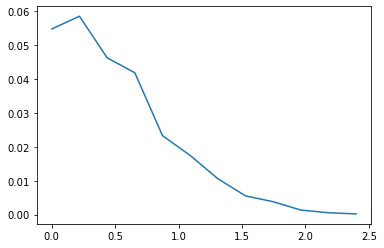

In [148]:
plt.plot(np.linspace(0,2.4,12), mcResult)

### Application #2: Finding the first excited state

So, getting the ground state energy was a cool trick. How about higher energies? It looks like we are going to need another trick. Consider the quantity

$$ \left<x(t_2)x(t_1)\right> \equiv \frac{\int D[x] x(t_2)x(t_1)e^{-S[x]}}{\int D[x] e^{-S[x]}} $$

where now, we integrate over all x; that is we now include $ x = x_f $ & $ x = x_i $ (why?). By definition of the time evolution operator, the numerator is

$$ \left<x(t_2)x(t_1)\right> = \int \bra{x}e^{-H(t_f - t_2)}\tilde{x}e^{-H(t_2 - t_1)}\tilde{x}e^{-H(t_1 - t_i)}\ket{x} $$

(what is $ \tilde{x} $ ?). With $ T=t_f - t_i $ & $ t = t_2 - t_1 $,

$$ \left<x(t_2)x(t_1)\right> = \frac{\sum e^{-E_nT}\bra{E_n}\tilde{x}e^{-(H-E_n)t} \tilde{x} \ket{E_n}} {\sum e^{-E_nT}} $$

Again, when T>>t and is large, then the ground state dominates, and if t is large (but $ T >> t $ still,

$$
\begin{align} G(t) &\equiv \left<x(t_2)x(t_1)\right> \longrightarrow \bramket{E_0}{\tilde{x}e^{-(H-E_n)t}\tilde{x}}{E_0}
                     & \longrightarrow \left|\bramket{E_0}{\tilde{x}}{E_1}\right|^2 e^{-(E_1 - E_0)t}... 
\end{align} $$
                     
We can manipulate this expression to find $E_1$:

$$ ln G(t) = 2ln(\bramket{E_0}{\tilde{x}}{E_1} - (E1 - E0)t $$
$$ ln \left(G(t)/G(t+a)\right) \longrightarrow (E_1 - E_0)a $$

### The Metropolis Algorithm: A computational speed-up

These path integrals averages $ \left<\Gamma [x] \right> $ of arbitrary functionals $ \Gamma [x] $ can be used to compute any physical property of the excited states. Note

$$ \left<\Gamma[x]\right> = \frac{\int D[x] \Gamma[x]e^{-S[x]}}{\int D[x] e^{-S[x]}} $$

We call the Monte Carlo uncertainty $ \sigma_{\bar{\Gamma}} $. This will never be zero, since the number of paths will never be infinite, and is a potential source of error estimated as

$$ \sigma^2_{\bar{\Gamma}} \approx \frac{1}{N} \left[ \frac{1}{N} \sum^{N}_{\alpha=1} \Gamma^2 [x^{\alpha}] - \bar{\Gamma}^2 \right] 
                            \longrightarrow \frac{\left<\Gamma^2 \right> - \left<\Gamma\right>^2 }{N} $$
                            
For N large, the statistical uncertainties are supposed to vanish.

What if we could create some specialized random-vector generator that would create our Monte-Carlo set of paths that *already has* the probability weighting $ P[x] = e^{-S[x]} $ included in it? That way, we wouldn't have to create so many paths and weigh them afterwards!

The Metropolis Algorithm begins with a random path $ x_0 $. $x_0$ is modified at each lattice point, creating a new (or *updated*) path $ x_1 $. We want to do something with $ \Delta S $....

The algorithm steps are as follows:
1. Initialize the first path $ x_0 $ to all 0's. Set a 
2. Update the path: for the $ j^{th} $ lattice site on the $ n^{th} $ path $ x^n_j $,
     1. Generate a random number $ \delta $, and consider the same path with $ x^n_j \rightarrow x^n_j + \delta $; 
     2. If the action is reduced $ \Delta S < 0 $ between these two paths, keep the new $ x_j $ and proceed to the next value of j.
        If the action is increased $ \Delta S > 0 $ between these two paths; if $ e^{-\Delta S} > \eta $, keep the new $ x_j $. Otherwise, restore the old value and move on to the next lattice point.
3. Keep the path. Repeat the update N times
4. Average the paths to get the estimate
        
The Metropolis Algorithm is 'not always the best' [?], and there are a couple of optimization techniques we will use. 
1. Thinning out correlated paths
    1. Adjusting epsilon - it has been advised that one keeps track of the "success" rate of the update step (2) and adjust epsilon so taht it has about 50% success. This has already been tweaked.
    2. Cutting
2. Thermalizing the lattice

In [13]:
def dS_n(x,N,n):
    KE = m/a * x[n]*(x[n] - x[n+1] - x[n-1])
    PE = a * harmonicV(x[n])
    
    return KE+PE

def H(x,N):
    KE, PE = 0.,0.
    
    for n in range(N-1):
        KE += m/(2*a) * (x[n+1] - x[n])**2
        PE += a * harmonicV(x[n])
        
    return (KE+PE)

def maUpdate(x, N, eps):
    for n in range(N-1):
        dS_old = dS_n(x,N,n)
        xi = np.random.uniform(-eps, eps)

        x[n] += xi
        
        dS_new = dS_n(x, N, n)
        
        dS = dS_new - dS_old
        
        if dS > 0 and np.exp(-dS) < np.random.uniform(0,1): ################
            x[n] -= xi
            
def maMC_integrate(func, bounds, N, eps, N_cor, N_cf):
    # Intialize
    x = np.zeros(N)
    avg_f = 0
    
    # Update
    for j in range(5*N_cor):
        maUpdate(x,N,eps)

    for alpha in range(N_cf):
        for j in range(N_cor):
            maUpdate(x,N,eps)
        

        avg_f += func(x,N)
            
    avg_f = avg_f/N_cf/N
        
    return avg_f


In [20]:
N = 20 # time steps
ti,tf = 0,N/2 # Initial time and Final time stamps
a = (tf - ti)/ N # Grid spacing
m = 1 # particle mass
k = 1 # oscillator strength
A = (m/(2*np.pi*a))**(N/2) # Wave function normalization

N_cor = 20 # Number of paths to skip in order to thermalize
N_cf = 2500  # Number of paths to generate after thermalization
eps = 1.4
xi = np.random.uniform(-eps,eps)

In [21]:
maMCresult = maMC_integrate(H, xBounds, N, eps, N_cor, N_cf)
print(maMCresult)

0.4601204286707648


### Revisited: The harmonic oscillator

### Statistical Errors

There are always statistical errors that vanish only in the limit where infinitely many configurations are employed: $ N_{cf} \rightarrow \infty $. The crude way to get the statistical uncertainty on our expectation value is to run the calculation many times, and deduce the uncertainty from those trials. The main source of computational expense comes from the generation of new random numbers.

This is where the bootstrap procedure comes in. Given $ N_{cf} $ measurements of an expectation value $ \bar{E} $, we can construct a "bootstrap copy" of the ensemble by selectring frandom $ \bar{E} ^ \alpha $'s at random from the original ensemble taking $ N_{cf} $ random samples from our $ N_{cf} $ paths: the bootstrap copy is allowed to contain duplicates. This new ensemble can be averaged to obtain a new estimate for $ \bar{E} $. By repeating this procedure many times, we can generate a distribution of $ \bar{E} $'s with the same distribution of that generated by the original Monte Carlo method!


Missing: Section on binning

Missing: code realization

## Field theory on a Lattice

From quantum mechanics to field theory, the analogous quantity of interest turns from $ x(t) \longrightarrow $ to fields $ \phi(x) $ or $ A_u(x) $ where x now represents the four position $ x = (t, \vec{x}) $. The analogy to the QM ground state is the vacuum state $ \ket{0} $: the analogous excited states created by $ \phi^{m} \ket{0} $ with $ m \in N $, and they now correspond to $ r $ particles.

In the lattice approximation, both space and time are discrete. The nodes, or **sites**, of the grid are separated by lattice spacing a, with total side length L. The lines which join sites along basis vectors are called **links**. The quantum field can be specified by its values at the grid sites

<!-- ![alt](FieldOnALattice_1.png) | ![alt](LatticeVocab.png) -->

<table>
    <td> <img src="LatticeVocab.png" alt="Drawing" style="width: 250px;"/> </td><td> <img src="FieldOnALattice_1.png" alt="Drawing" style="width: 250px;"/> </td>
</table>

A field configuration is described by the set of its values on grid sites $ \phi(x_j), \forall \ x_j \in grid $. The path integral generalizes as 

$$ \left<\Gamma[\phi]\right> \equiv \frac{1}{Z} \int e^{-S[\phi]} \Gamma[\phi] \ \prod_{x_j \in grid} d\phi(x_j) $$

where $ Z $ is the normalization 

$$ \int e^{-S[\phi]} \prod_{x_j \in grid} d\phi(x_j) $$

We will get to the meaning of $ S[\phi] $ soon. With this formulism, we study excitations of the field theory with operators like

$$ \Gamma(t) \equiv \frac{1}{\sqrt{N}} \sum_{\vec{x}_j} \phi(\vec{x}_j,t) $$

The sum over $ N $ spatial $ \vec{x}_j $'s enforces zero three-momentum (?). The analagous excited states, being linked to particle creation, are actually the energies of the particles themselves: our analogy continues (missing: repeat QM expression)

$$ \left<\Gamma(t)\Gamma(0)\right> \longrightarrow ^{t large} \left| \bramket{0}{\Gamma(0)}{\phi: \vec{p} = \vec{0}} \right| ^2 e^{-m_\phi t} $$

This is a $ \phi $ 1-particle state with 0 three-momentum and mass $ m_\phi $.

### Coarse discretization of lattices

Early enthusiasm for computational approaches to QCD where cooled by sobering estimates of the computational expense of numerically evaluating path integrals. Today, these problems have been impressively (but not absolutely mitigated). One reason is obviously the exponential increase in computational power. The other is actually... idk how to condense

$$ cost \approx \left(\frac{L}{a}\right)^4 \frac{1}{a} \frac{1}{m^2_\pi a} $$

In field theory, the field-momentum is a little more abract, namely $ \left(\partial_\mu \phi \right)^2 \neq \partial^2_\mu \phi $. We need an expression for the RHS of the previous equation: try

$$ \frac{\partial\phi(x)}{\partial x} = \frac{1}{a} \left(\phi_{x} - \phi_{x-a} \right) + \vartheta(a) $$
$$ \frac{\partial^2 \phi(x)}{\partial x^2} = \frac{1}{a^2} \left[\left(\phi(x+a) - \phi(x)\right) - \left(\phi(x) - \phi(x-a)\right) \right] + \vartheta(a^2) = \frac{1}{a^2} \left[\phi(x-a) + \phi(x+a) - 2\phi(x)\right] + \vartheta(a^2) $$

There is one better, though I offer no explanation. Defining the previous quantity as

$$ \Delta^{(2)}_x \phi(x) = \frac{1}{a^2} \left[\phi(x-a) + \phi(x+a) - 2\phi(x)\right] $$

we will be using

$$ \frac{\partial^2 \phi(x_j)}{\partial x^2} \equiv \Delta^{(2)}_{x_j} \phi(x_j) - \frac{a^2}{12} (\Delta^{(2)}_{x_j} \phi(x))^2 \phi(x_j) + \vartheta(a^4) $$

going forward. This is claimed to be accurate to a few percent even when acting on structures in $ \phi(x) $ that are as small as 4-5 lattice spacings across [?]. The naive expectation is that investigating hadrons will require lattice spacings of only ~.2 of their diameter. However, consideration must be given to the shortest wavelengths we are able to model on a lattice spaced like that. 

The minimum oscillation we are able to model has wavelength $ \lambda_{min} = 2a $--the oscillation finishes at an adjacent site. This means that gluons and quarks with momenta $ p = 2\pi/\lambda $ larger than $ 2\pi/\lambda_{min} = \pi/a $ are excluded from our calculations, acting as a filter or an ultraviolet cutoff. For noisy nonlinear interacting quantum field theories, ultraviolet modes strongly affect lower energy states. 

Luckily, smart people have figured out how to mimic the effect on lower energy states. It's done by changing, or 'renormalizing', the parameters in the discretized theory and by adding new local interactions. As an example, the discretized kinetic Lagrangian for an interacting scalar theory is

$$ \sum_\mu \frac{1}{2} \phi^\dagger \partial_{\mu^2} \phi \longrightarrow \sum_\mu \frac{1}{2} \left( \phi^\dagger \Delta^{(2)}_x \phi(x) \phi + a^2 c (\phi^\dagger \Delta^{(2)}_x \phi(x))^2 \right) $$

where c is a parameter with two parts: $ \frac{-1}{12} $ from our numerical derivative, and an additional renormalization due to cutoff. The later is typically context dependent and must be computed using QFT. Since QCD is perturbative at high energies, we can write $c$ for it as a function of the running strong coupling

$$ c = \frac{-1}{12} + c_1 \alpha_s(\pi/a) + c_2 \alpha^2_s(\pi/a) \ + \ ... $$

According to Lepage (2005), this perturbative approach works for lattice spacings smaller than 0.05-0.1 fm.


### A test of the new action

## QCD on a Lattice

### Building a gauge invariant lattice theory

#### Important definition: The Wilson Loop function

### Quantum Gluons: Quantum effects in perturbation theory

### Monte Carlo Evaluation of Path Integrals

### Our first application of Lattice QCD

#### Another computational speedup: Smeared links

## References